# 4개 모델 성능 비교
```
4개 모델 성능 비교표
        
    모델	Accuracy	Recall (flood=1)	ROC AUC
RandomForest	0.9811	         0.8000	                0.9843
XGBoost     	0.9641	         0.8765              	0.9775
LSTM+CNN	0.5873	         0.8642              	0.7688
Transformer	0.7299	         0.6790              	0.7812

해석 요약
RandomForest: 전체적으로 가장 안정적. Accuracy, Recall, ROC AUC 모두 우수.

XGBoost: 침수 예측(Recall)에 가장 뛰어남. 성능 균형 좋음.

LSTM+CNN: Accuracy는 낮지만 Recall은 높아, 침수 감지엔 민감한 편.

Transformer: Recall은 나쁘지 않지만 Precision이 낮고 전체 정확도도 낮은 편.
```

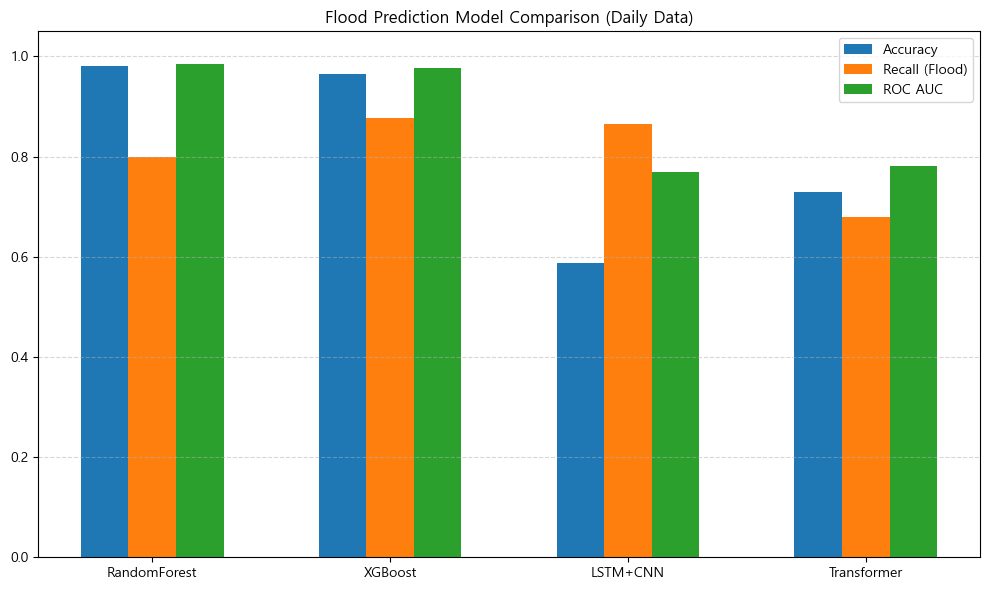

In [24]:
import matplotlib.pyplot as plt

models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer"]
accuracy = [0.9811, 0.9641, 0.5873, 0.7299]
recall = [0.8000, 0.8765, 0.8642, 0.6790]
roc_auc = [0.9843, 0.9775, 0.7688, 0.7812]

plt.figure(figsize=(10, 6))
x = range(len(models))

plt.bar(x, accuracy, width=0.2, label="Accuracy", align="center")
plt.bar([i + 0.2 for i in x], recall, width=0.2, label="Recall (Flood)", align="center")
plt.bar([i + 0.4 for i in x], roc_auc, width=0.2, label="ROC AUC", align="center")

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.05)
plt.title("Flood Prediction Model Comparison (Daily Data)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("daily_model_comparison.png")
plt.show()

# 한글설정, 워닝제거

In [1]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

# api key 활용 및 데이터 수집

In [2]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# 실제 침수 사례와 30mm이상 강수량을 침수예측 데이터로 합치기

In [9]:
import pandas as pd
import datetime

# 1. 데이터 불러오기
df = pd.read_csv("asos_seoul_daily.csv")

# 2. 결측치가 많은 컬럼 제외하고 필요한 컬럼 선택
# sumRn (일강수량) 기준, 나머지는 평균 기온, 평균 습도 등 주요 변수
useful_cols = ['tm', 'avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs', 'avgRhm', 'avgTs', 'avgTd', 'avgPs']
df = df[useful_cols]

# 3. 결측치 제거
df = df.dropna()

# 4. 날짜 타입 변환
df['tm'] = pd.to_datetime(df['tm'])

# 5. 실제 침수 날짜 수동 지정
flood_periods = [
    ("2000-08-23", "2000-09-01"),
    ("2002-08-30", "2002-09-01"),
    ("2005-08-02", "2005-08-11"),
    ("2006-07-09", "2006-07-29"),
    ("2007-09-13", "2007-09-13"),
    ("2011-07-26", "2011-07-29"),
    ("2013-07-11", "2013-07-15"),
    ("2013-07-18", "2013-07-18"),
    ("2018-08-23", "2018-08-24"),
    ("2018-08-26", "2018-09-01"),
    ("2019-09-28", "2019-10-03"),
    ("2020-07-28", "2020-08-11"),
    ("2020-08-28", "2020-09-03"),
    ("2020-09-01", "2020-09-07"),
    ("2022-08-08", "2022-08-17"),
    ("2022-08-28", "2022-09-06"),
]

# 6. 수동 침수일 set 생성
flood_dates = set()
for start, end in flood_periods:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    flood_dates.update(dates)

# 7. flood_risk 컬럼 생성: 침수일이거나, 강수량이 30mm 이상인 날
df['flood_risk'] = df.apply(lambda row: 1 if (row['tm'] in flood_dates or row['sumRn'] >= 30) else 0, axis=1)

# 8. 결과 저장
df.to_csv("asos_seoul_daily_with_flood_risk.csv", index=False)

# 9. 클래스 분포 확인
print(" 저장 완료: asos_seoul_daily_with_flood_risk.csv")
print(" 클래스 분포:")
print(df['flood_risk'].value_counts())


 저장 완료: asos_seoul_daily_with_flood_risk.csv
 클래스 분포:
0    3214
1     403
Name: flood_risk, dtype: int64


# XGBoost ML

In [10]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
df = pd.read_csv("asos_seoul_daily_with_flood_risk.csv")

# 2. 입력/출력 컬럼 설정
features = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs', 'avgRhm', 'avgTs', 'avgTd', 'avgPs']
target = 'flood_risk'

X = df[features]
y = df[target]

# 3. 정규화
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 4. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# 5. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 6. XGBoost 모델 학습
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_resampled, y_train_resampled)

# 7. 예측 및 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 8. 결과 출력
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
 [[627  16]
 [ 10  71]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9843    0.9751    0.9797       643
           1     0.8161    0.8765    0.8452        81

    accuracy                         0.9641       724
   macro avg     0.9002    0.9258    0.9125       724
weighted avg     0.9655    0.9641    0.9646       724


ROC AUC Score: 0.9774974559837183


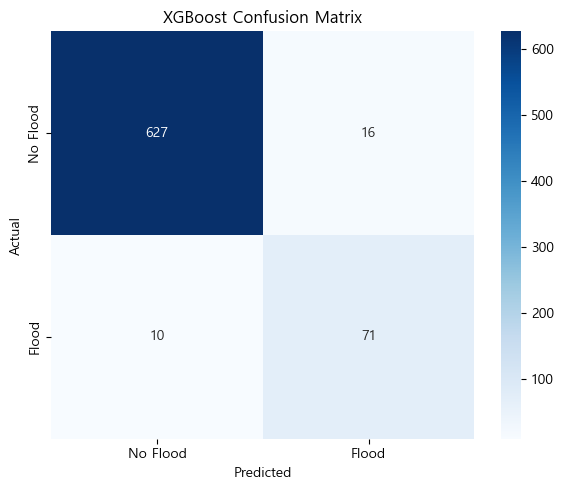

In [11]:
# 9. 시각화 (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood', 'Flood'], yticklabels=['No Flood', 'Flood'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost Confusion Matrix")
plt.tight_layout()
plt.savefig("xgboost_confusion_matrix.png")
plt.show()

# 성능 요약
```
지표	값
Accuracy	96.41%
Precision (1)	81.61%
Recall (1)	87.65%
F1-Score (1)	84.52%
ROC AUC Score	0.9775
```

# 모델 저장하기

In [13]:
# 12. 모델 및 스케일러 저장
joblib.dump(model, "rf_flood_daily_model.pkl")
joblib.dump(scaler, "rf_flood_daily_scaler.pkl")

['rf_flood_daily_scaler.pkl']

# 시각화하기

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    f1_score,
    average_precision_score
)

# Confusion Matrix 시각화
def plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ROC Curve 시각화
def plot_roc_curve(y_test, y_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Precision-Recall Curve 시각화
def plot_precision_recall_curve(y_test, y_proba, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap_score = average_precision_score(y_test, y_proba)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, label=f'AP = {ap_score:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.show()

# F1 Score 출력
def print_f1_score(y_test, y_pred):
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

# 예측하기

In [22]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

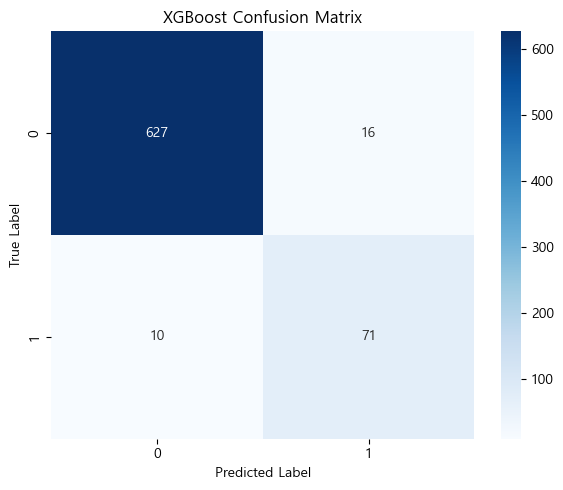

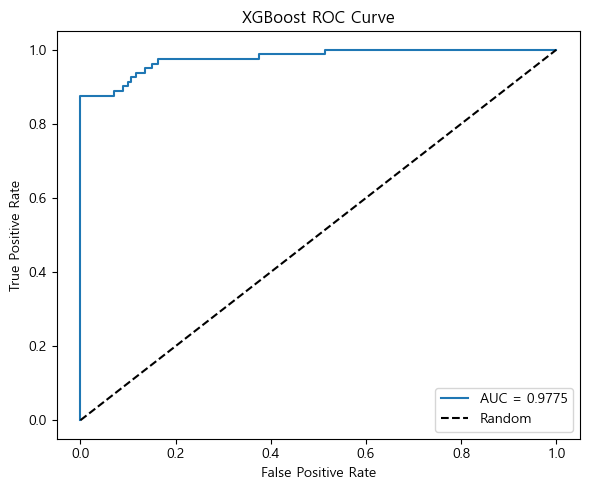

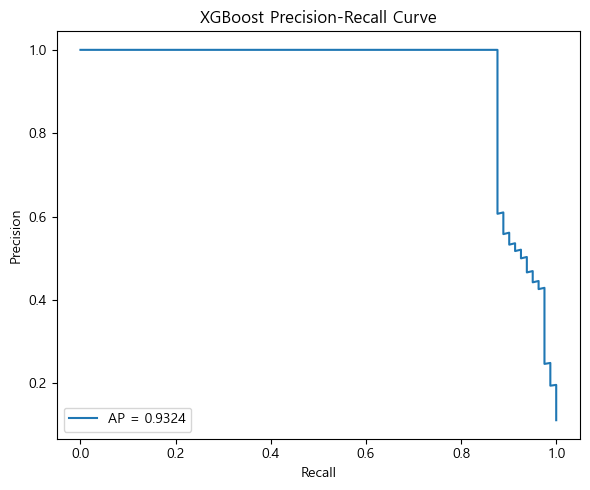

F1 Score: 0.8452


In [23]:
plot_confusion_matrix(y_test, y_pred, "XGBoost Confusion Matrix")
plot_roc_curve(y_test, y_proba, "XGBoost ROC Curve")
plot_precision_recall_curve(y_test, y_proba, "XGBoost Precision-Recall Curve")
print_f1_score(y_test, y_pred)